In [ ]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [ ]:
 
!pip install -U -q PyDrive 
 
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
 
 
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1VAdjHhhlRj1HiX37wvGzrBp42x4AZnAX/view'
 
import pandas as pd 
 
# to get the id part of the file 
id = link.split("/")[-2] 
 
downloaded = drive.CreateFile({'id':id}) 
downloaded. GetContentFile('fer2013.csv') 
 
df = pd.read_csv('fer2013.csv') 
print(df)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 70
width, height = 48, 48

In [ ]:
df.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


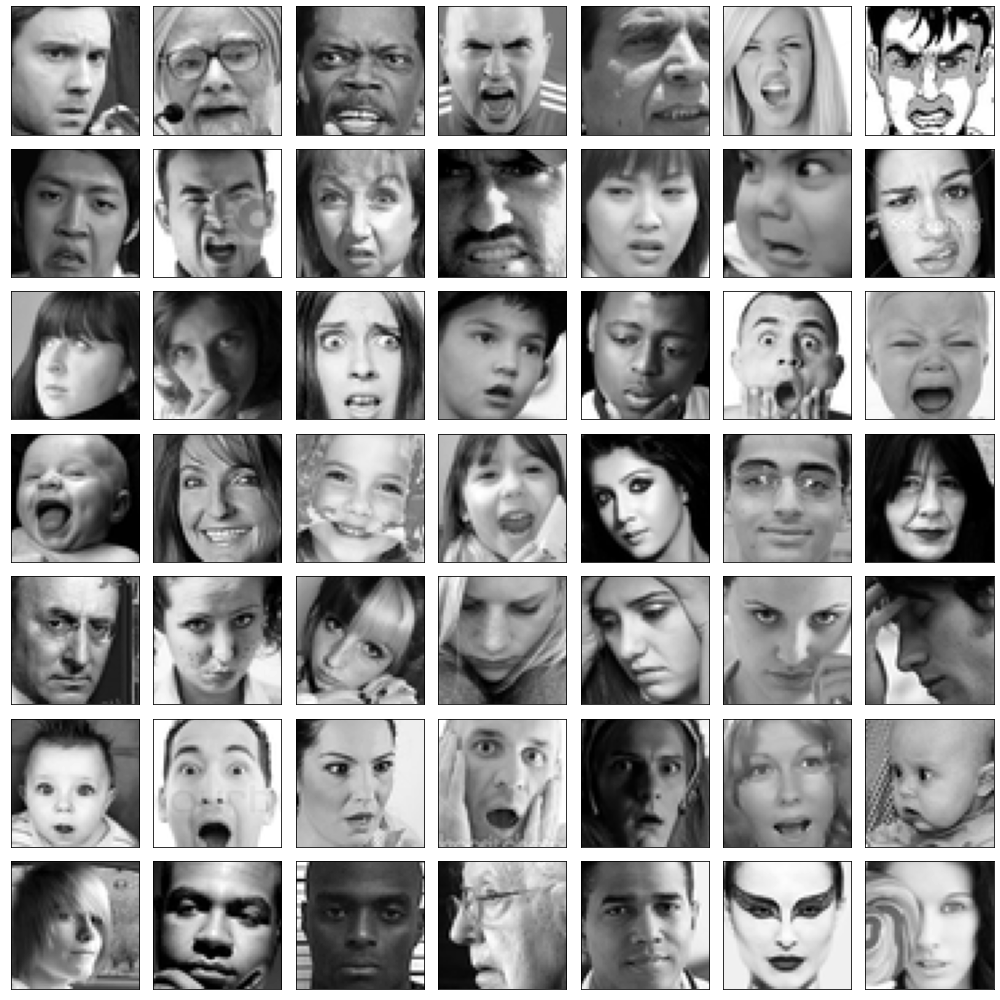

In [ ]:
import matplotlib.pyplot as plt
emotion_label_to_text = {0:'angry', 1:'disgust' 2:'fear', 3:'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

fig = plt.figure(1, (14, 14))
 
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
 
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [ ]:
pixels = df['pixels'].tolist() # 1
 
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # 2
    face = np.asarray(face).reshape(width, height) # 3
    
    # There is an issue for normalizing images. Just comment out 4 and 5 lines until when I found the solution.
    # face = face / 255.0 # 4
    # face = cv2.resize(face.astype('uint8'), (width, height)) # 5
    faces.append(face.astype('float32'))
 
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1) # 6
 
emotions = pd.get_dummies(df['emotion']).to_numpy() # 7

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

In [ ]:
model = Sequential()
 
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
 
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
 
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
 
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
 
model.add(Flatten())
 
model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))
 
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

In [ ]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

In [ ]:
tensorboard = TensorBoard(log_dir='./logs')

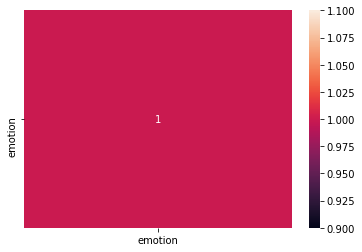

In [ ]:
import seaborn as sb
sb.heatmap(df.corr(), annot=True)

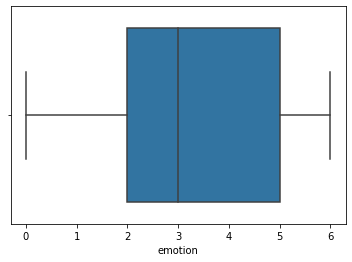

In [ ]:
sb.boxplot(x='emotion', data=df)

In [ ]:
history= model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True,
          callbacks=[lr_reducer, tensorboard, early_stopper])

Epoch 1/70
455/455 [==============================] - 55s 46ms/step - loss: 2.3346 - accuracy: 0.1973 - val_loss: 1.8004 - val_accuracy: 0.2575
Epoch 2/70
455/455 [==============================] - 19s 42ms/step - loss: 1.8148 - accuracy: 0.2546 - val_loss: 1.7117 - val_accuracy: 0.2987
Epoch 3/70
455/455 [==============================] - 19s 42ms/step - loss: 1.7116 - accuracy: 0.3140 - val_loss: 1.6756 - val_accuracy: 0.3268
Epoch 4/70
455/455 [==============================] - 19s 42ms/step - loss: 1.5962 - accuracy: 0.3712 - val_loss: 1.6894 - val_accuracy: 0.3235
Epoch 5/70
455/455 [==============================] - 19s 42ms/step - loss: 1.5307 - accuracy: 0.4046 - val_loss: 1.5538 - val_accuracy: 0.3683
Epoch 6/70
455/455 [==============================] - 19s 43ms/step - loss: 1.4663 - accuracy: 0.4195 - val_loss: 1.4271 - val_accuracy: 0.4129
Epoch 7/70
455/455 [==============================] - 19s 43ms/step - loss: 1.4171 - accuracy: 0.4340 - val_loss: 1.3791 - val_accuracy:

In [ ]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

57/57 [==============================] - 1s 14ms/step - loss: 1.0873 - accuracy: 0.6500
Loss: 1.0873197317123413
Accuracy: 0.6500418186187744


In [ ]:
fer_json = model.to_json()
with open("fermodel.json","w") as json_file:
    json_file.write(fer_json)
model.save_weights("fermodel.h5")

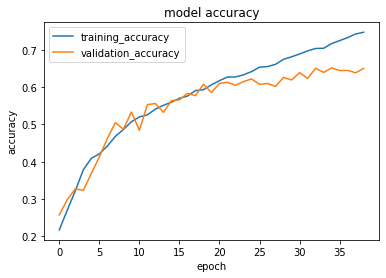

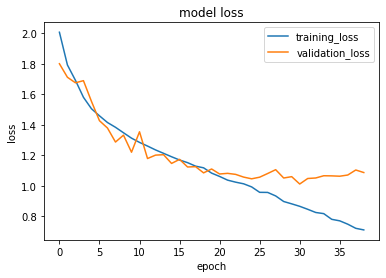

In [ ]:

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)


# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training_accuracy', 'validation_accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper right')
plt.show()



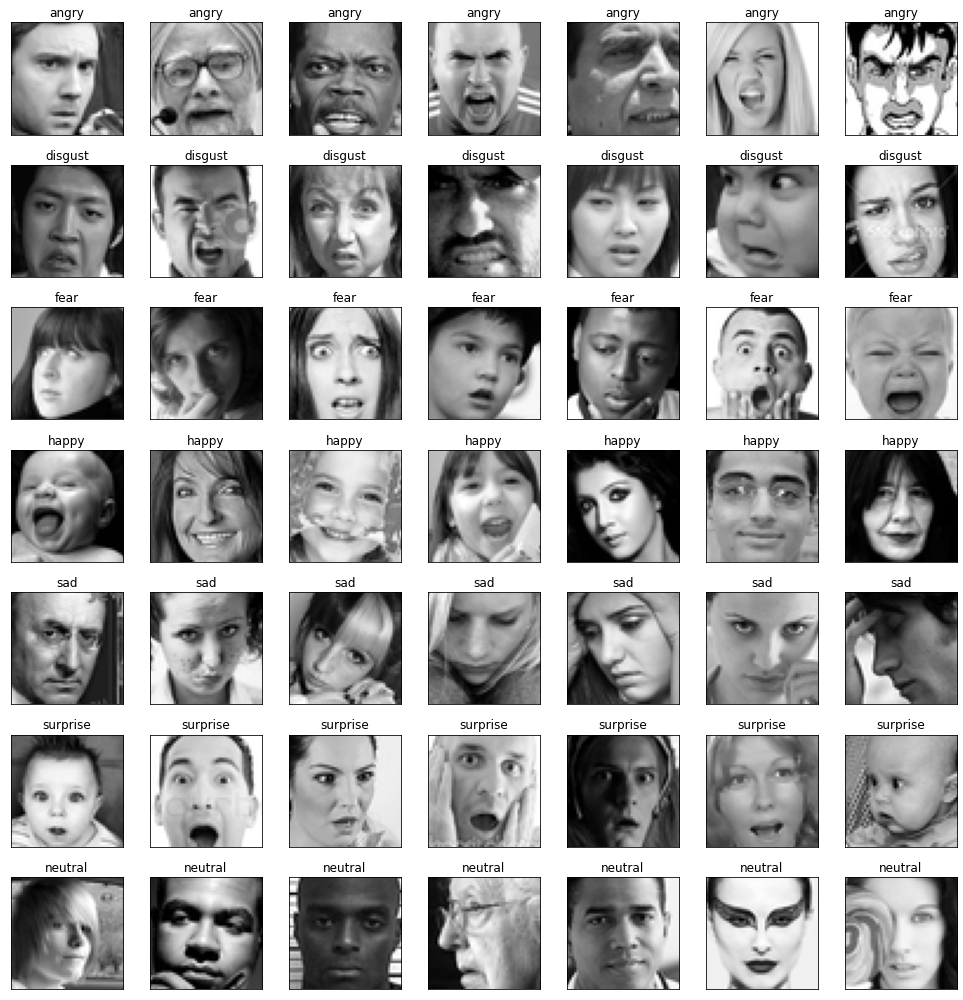

In [ ]:
import matplotlib.pyplot as plt
emotion_label_to_text = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

fig = plt.figure(1, (14, 14))
 
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
 
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [ ]:
model.save_weights('fermodel.h5')


In [ ]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
 
model.load_weights('fermodel.h5')
 
cap = cv2.VideoCapture(0)
 
while True:
    ret, frame = cap.read()
 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
 
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 1)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        prediction = model.predict(cropped_img)
        cv2.putText(frame, emotion_dict[int(np.argmax(prediction))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
 
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
cap.release()
cv2.destroyAllWindows()

error: ignored